# MINE4201- SR -  Laboratorio 1 
# Exploración modelos KNN



Vamos a utilizar las siguientes librerias en el laboratorio


In [ ]:
!pip install numpy
!pip install scikit-surprise
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366422 sha256=87c8fb8fba5cce7f577601721d0e48c6ac7b033f8b4c8603e37d41a9672e5370
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pwd

'/content'

In [ ]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)


## Suba al servidor los archivos u.data y u.item que se encuentran en el dataset descargado, en la pestaña files

In [ ]:
if not (os.path.exists('/content/u.data') and os.path.exists('/content/u.item')):
  raise ValueError('Los archivos u.data e u.item no fueron encontrados en el path')
else:
  print("Los archivos han sido cargados")

Los archivos han sido cargados


In [ ]:
ratings=pd.read_csv('/content/u.data', sep = '\t', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ] )

In [ ]:
items=pd.read_csv('/content/u.item', sep = '\|', names = ['movie id' ,'movie title','release date','video release date','IMDb URL ','unknown',
                                                          'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
                                                          'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'], encoding='latin-1' )

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Verifique que los ratings y los items hayan sido cargados correctamente





In [ ]:
#ratings.rating=ratings.rating.astype('category')
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
print(ratings.item_id.value_counts().tail(141))
print('-----')
print(len(ratings.item_id.value_counts()))

1673    1
599     1
1648    1
1309    1
1581    1
       ..
852     1
1505    1
1653    1
1452    1
1641    1
Name: item_id, Length: 141, dtype: int64
-----
1682


In [ ]:
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Visualice la distribución de ratings, ¿Qué puede decir al respecto?

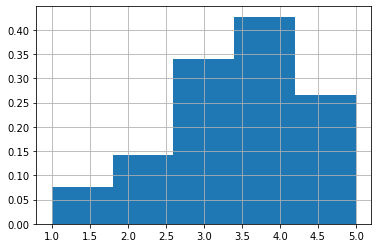

In [ ]:
ratings.rating.hist(density=1, bins=5, alpha=1, stacked=False)

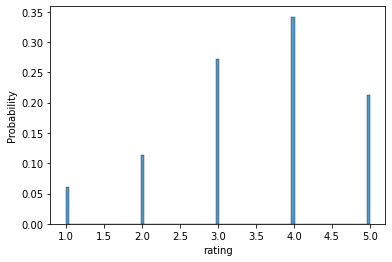

In [ ]:
import seaborn as sns
sns.histplot(ratings.rating, stat='probability')

Se identifica que hay una asimetría hacia los valores de rating positivos, esto se podría deber a alguna de las siguientes razones:

* Si la información proviene de algún sitio para calificar películas, puede ser que los usuarios hayan calificado películas que hayan visto porque les apareció como recomendada en alguan plataforma, en cuyo caso, el SR de la plataforma funciona relativamente bien
* Los usuarios vieron las películas que calificaron por voluntad propia y sin intervención de algún SR, por lo que, al ser una película de su interés, les haya terminado gustando.

## En la siguiente celda se esta calculando el número de ratings por usuario y  el promedio de sus calificaciones, el dataframe esta ordenado por el número de calificaciones

In [ ]:
ratings.groupby('user_id')['rating'].agg({'count','mean'}).sort_values(by='count', ascending=False)

,count,mean
user_id,,
405,737,1.834464
655,685,2.908029
13,636,3.097484
450,540,3.864815
276,518,3.465251
...,...,...
685,20,2.050000
475,20,3.600000
36,20,3.800000


In [ ]:
r_dist = ratings.groupby('user_id')['rating'].mean().reset_index()
r_dist

,user_id,rating
0,1,3.610294
1,2,3.709677
2,3,2.796296
3,4,4.333333
4,5,2.874286
...,...,...
938,939,4.265306
939,940,3.457944
940,941,4.045455
941,942,4.265823


##Utilice las siguientes celdas para encontrar respuesta a las siguientes preguntas

¿Cómo es la distribución del número de ratings por usuario?

Se identifica que más del 37% de usuarios no supera los 50 ratings y son relativamente pocos los que superan los 100 ratings, por lo que la matriz de utilidad, a crear sería dispersa, que concuerda con lo visto en clase

¿Cómo es la distribución del promedio de calificación por usuario?

Este se centra entre 3 y 4, con alrededor del 75% de usuarios ubicados en este rango, esto puede ser causado las siguientes razones:

* Los usuarios pueden tener una tendencia a calificar las películas hacia los extremos, es decir, 5 para gusto y 1 para disgusto o similar, vemos que este puede ser el caso para algunos usuarios puesto que el histograma de calificaciones en general sí muestra que estas áreas no están vacías. Lo que al final causa que el promedio sea cercano a la mediana.

* Por otro lado, otros usuarios, que según el histograma de calificaciones, son la mayoría, tienen la tendencia a no dar ratings cercanos a extremos, sino más bien neutrales, esto se confirma ya que alrededor del 60% de las calificaciones de películas son 3 o 4.


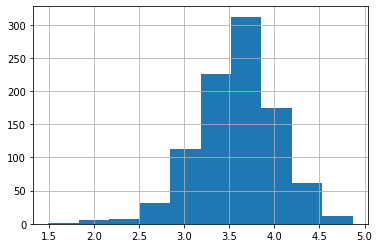

In [ ]:
r_dist.rating.hist()

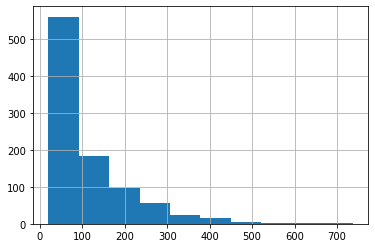

In [ ]:
dis_ratings_usuario = ratings.groupby('user_id')['rating'].agg({'count','mean'}).sort_values(by='count', ascending=False)
dis_ratings_usuario['count'].hist()

##En la siguiente celda se esta calculando el número de ratings por items, el promedio de sus calificaciones y la varianza de sus calificaciones. 

In [ ]:
ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

,count,var,mean,movie title
item_id,,,,
1,452,0.860992,3.878319,GoldenEye (1995)
2,131,0.934116,3.206107,Four Rooms (1995)
3,90,1.470787,3.033333,Get Shorty (1995)
4,209,0.931358,3.550239,Copycat (1995)
5,86,0.895759,3.302326,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...
1678,1,NaN,1.000000,B. Monkey (1998)
1679,1,NaN,3.000000,Sliding Doors (1998)
1680,1,NaN,2.000000,You So Crazy (1994)


##Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuáles son los items con más calificaciones?  

|Nombre|Cantidad de calificaciones|
|---|:---:|
|Legends of the Fall (1994)|583|
|George of the Jungle (1997)|509|
|Heavy Metal (1981)|508|
|GoodFellas (1990)|507|
|Breakdown (1997)|485|
|Marvin's Room (1996)|481|
|Evita (1996)|478|
|GoldenEye (1995)|452|
|In & Out (1997)|431|
|Cable Guy, The (1996)|429|

¿Se puede observar el fenomeno de cola larga en este dataset?

- Sí se puede observar una cola larga porque cerca del 47% de calificaciones ocurren únicamente en las 300 películas con mas ratings, con el 15%  centrado en el top 100




In [ ]:
mt=ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

In [ ]:
mt

,count,var,mean,movie title
item_id,,,,
1,452,0.860992,3.878319,GoldenEye (1995)
2,131,0.934116,3.206107,Four Rooms (1995)
3,90,1.470787,3.033333,Get Shorty (1995)
4,209,0.931358,3.550239,Copycat (1995)
5,86,0.895759,3.302326,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...
1678,1,NaN,1.000000,B. Monkey (1998)
1679,1,NaN,3.000000,Sliding Doors (1998)
1680,1,NaN,2.000000,You So Crazy (1994)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f31f73940>,
      dtype=object)

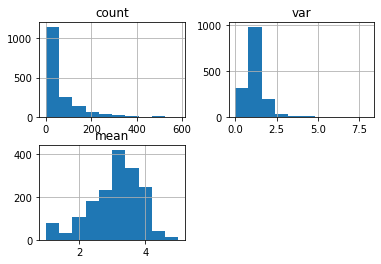

In [ ]:
mt.hist()

In [ ]:
mt['count'][0:4].sum()

882

In [ ]:
mt['count'][0:100].sum()

14892

In [ ]:
mt['count'][0:300].sum()

47063

In [ ]:
mt.sort_values(by='count', ascending=False)

,count,var,mean,movie title
item_id,,,,
50,583,0.776762,4.358491,Legends of the Fall (1994)
258,509,0.988885,3.803536,George of the Jungle (1997)
100,508,0.952100,4.155512,Heavy Metal (1981)
181,507,0.853693,4.007890,GoodFellas (1990)
294,485,1.206799,3.156701,Breakdown (1997)
...,...,...,...,...
1576,1,NaN,1.000000,"Death in the Garden (Mort en ce jardin, La) (1..."
1577,1,NaN,1.000000,"Collectionneuse, La (1967)"
1348,1,NaN,1.000000,Mille bolle blu (1993)


## Creación de listas de recomendación no personalizadas

Genere inicialmente una lista de recomendación de tamaño 10 no personalizada con los items con mejor promedio, en teoría estos son los mejores items del dataset.

¿Qué problemas tiene generar una lista no personalizada solamente con el promedio?

- No se tienen en cuenta la cantidad de calificaciones, por lo que items con pocas pero buenas calificaciones terminan siendo los recomendados. 

¿Es posible generar una mejor lista de recomendación teniendo en cuenta que tanto el número de ratings del item como su promedio?

- Sí, usando el score Wilson para un parámetro de Bernoulli tal cual lo menciona el enlace #1

Ver: 

http://www.evanmiller.org/how-not-to-sort-by-average-rating.html

https://es.wikipedia.org/wiki/Intervalo_de_confianza


In [ ]:
list_no_per = mt.sort_values(by='mean', ascending=False)
list_no_per.pop('var')
list_no_per[0:10].sort_values(by='count', ascending=False)

,count,mean,movie title
item_id,,,
1293,3,5.0,Ayn Rand: A Sense of Life (1997)
1189,3,5.0,That Old Feeling (1997)
1500,2,5.0,Prisoner of the Mountains (Kavkazsky Plennik) ...
1467,2,5.0,"Cure, The (1995)"
814,1,5.0,One Fine Day (1996)
1599,1,5.0,Guantanamera (1994)
1201,1,5.0,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)"
1122,1,5.0,"Last Time I Saw Paris, The (1954)"
1653,1,5.0,Chairman of the Board (1998)


In [ ]:
ratings[ratings.item_id == 3].count()

user_id      90
item_id      90
rating       90
timestamp    90
dtype: int64

In [ ]:
ratings[ratings.item_id == 3].rating.mean()

3.033333333333333

In [ ]:
# genera nueva columna de ratings positivos, para aquellos > 3
ratings['pos'] = ratings.rating.apply(lambda x: True if x > 3 else False)
ratings

,user_id,item_id,rating,timestamp,pos
0,196,242,3,881250949,False
1,186,302,3,891717742,False
2,22,377,1,878887116,False
3,244,51,2,880606923,False
4,166,346,1,886397596,False
...,...,...,...,...,...
99995,880,476,3,880175444,False
99996,716,204,5,879795543,True
99997,276,1090,1,874795795,False
99998,13,225,2,882399156,False


In [ ]:
ratings_pos = ratings.groupby('item_id').pos.sum()

In [ ]:
ratings_pos

item_id
1       321
2        51
3        34
4       122
5        39
       ... 
1678      0
1679      0
1680      0
1681      0
1682      0
Name: pos, Length: 1682, dtype: int64

In [ ]:
mr_pos = ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(ratings_pos, how='left').join(items['movie title'], how='left')

In [ ]:
mr_pos

,count,var,mean,pos,movie title
item_id,,,,,
1,452,0.860992,3.878319,321,GoldenEye (1995)
2,131,0.934116,3.206107,51,Four Rooms (1995)
3,90,1.470787,3.033333,34,Get Shorty (1995)
4,209,0.931358,3.550239,122,Copycat (1995)
5,86,0.895759,3.302326,39,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...,...
1678,1,NaN,1.000000,0,B. Monkey (1998)
1679,1,NaN,3.000000,0,Sliding Doors (1998)
1680,1,NaN,2.000000,0,You So Crazy (1994)


In [ ]:
# crea lower_bound que es el rating mínimo @95% de confianza
def low_bound(x):
  z = 1.96
  pos = x['pos']
  n = x['count']
  phat = pos/n
  a = phat*(1-phat)
  b = z**2/(4*n)
  sqrt = np.sqrt((a + b)/n)
  lb = (phat + z**2/(2*n) - z*sqrt)/(1+z**2/n)
  return lb


In [ ]:
mr_pos['low_bound'] = mr_pos.apply(low_bound, axis=1)

In [ ]:
mr_pos

,count,var,mean,pos,movie title,low_bound
item_id,,,,,,
1,452,0.860992,3.878319,321,GoldenEye (1995),0.666720
2,131,0.934116,3.206107,51,Four Rooms (1995),0.310105
3,90,1.470787,3.033333,34,Get Shorty (1995),0.284558
4,209,0.931358,3.550239,122,Copycat (1995),0.515979
5,86,0.895759,3.302326,39,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,0.352514
...,...,...,...,...,...,...
1678,1,NaN,1.000000,0,B. Monkey (1998),0.000000
1679,1,NaN,3.000000,0,Sliding Doors (1998),0.000000
1680,1,NaN,2.000000,0,You So Crazy (1994),0.000000


In [ ]:
rec_lb = mr_pos.sort_values(by='low_bound', ascending=False)
rec_lb.pop('var')
rec_lb[0:10]

,count,mean,pos,movie title,low_bound
item_id,,,,,
64,283,4.445230,255,What's Eating Gilbert Grape (1993),0.860720
479,179,4.251397,162,North by Northwest (1959),0.853178
318,298,4.466443,265,Everyone Says I Love You (1996),0.848560
98,390,4.289744,344,Snow White and the Seven Dwarfs (1937),0.846252
483,243,4.456790,216,"Maltese Falcon, The (1941)",0.843166
603,209,4.387560,185,It Happened One Night (1934),0.834823
427,219,4.292237,193,Harold and Maude (1971),0.831730
50,583,4.358491,501,Legends of the Fall (1994),0.828769
357,264,4.291667,230,Spawn (1997),0.825420


In [ ]:
rec_lb

,count,mean,pos,movie title,low_bound
item_id,,,,,
64,283,4.445230,255,What's Eating Gilbert Grape (1993),8.607198e-01
479,179,4.251397,162,North by Northwest (1959),8.531785e-01
318,298,4.466443,265,Everyone Says I Love You (1996),8.485604e-01
98,390,4.289744,344,Snow White and the Seven Dwarfs (1937),8.462516e-01
483,243,4.456790,216,"Maltese Falcon, The (1941)",8.431665e-01
...,...,...,...,...,...
788,3,1.666667,0,Swimming with Sharks (1995),0.000000e+00
1408,3,1.000000,0,"Swan Princess, The (1994)",0.000000e+00
1407,20,2.250000,0,Gordy (1995),0.000000e+00


#Creación del dataset de entrenamiento y prueba

El próximo paso es cargar los datos a surprise, para esto vamos a inicializar un modelo de datos de surprise con la información de los ratings cargados en el dataframe

In [ ]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( ratings[ [ 'user_id', 'item_id', 'rating' ] ], reader )

Se divide el dataset en entrenamiento y test. El dataset de entrenamiento será presentado al algoritmo de recomendación y el dataset de test nos servirá para medir qué tan buenas fueron las predicciones del sistema de recomendación. El conjunto de test generado es una lista con los ratings de prueba

In [ ]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [ ]:
train_set.n_ratings

80000

In [ ]:
len(test_set)

20000

In [ ]:
#Este es el primer elemento del dataset de prueba (usuario 154, pelicula 302, rating 4)
test_set[0]

(154, 302, 4.0)

## Creación de modelo de filtrado colaborativo basado en similitud con usuarios o items cercanos

Surprise cuenta con la implementación de los modelos colaborativos dentro de la clase [KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) 

El modelo recibe los siguientes parámetros: 


*   k: El máximo número de vecinos con el que se hará la extrapolación
*   min_k : El mínimo número de vecinos con el que se extrapolará un rating
*   sim_options : Opciones de similitud pasadas como un diccionario de python, aqui se le configura al modelo el tipo de similitud a usar para encontrar los vecinos y si la extrapolación debe hacerse usando usuarios o items similares. Revise el formato y similitudes disponibles en surprise en [este link](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)





In [ ]:
# se crea un modelo knnbasic item-item con similitud coseno 
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [ ]:
#Se le pasa la matriz de utilidad al algoritmo 
algo.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Una vez cargados los ratings al modelo, se puede realizar una predicción para un usuario, en este caso vamos a calcular la predicción que el modelo esta realizando para la primera entrada del dataset de test la predicción para el usuario con id 154 y el item con id 302, que corresponde a la película L.A. Confidential (1997)

---



In [ ]:
#Verifique la propiedad est de la predicción
algo.predict(154,302)

Prediction(uid=154, iid=302, r_ui=None, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False})

In [ ]:
items[items['movie id']==302]

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
301,302,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


Como podemos ver, la predicción (4.24) del modelo no esta alejada de lo que realmente opinó el usuario  (4.0)

Para medir la calidad de la predicción para todos los usuarios e items del dataset de prueba, vamos a comparar lo que dice el modelo de predicción vs lo que dice el conjunto de prueba, para esto vamos a usar la métrica [RMSE](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.rmse)

Inicialmente calculamos la predicción para todos los elementos del conjunto de test

In [ ]:
test_predictions=algo.test(test_set)

In [ ]:
#5 primeras predicciones
test_predictions[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=2.8976616922320964, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=4.1968378983432535, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.0978778071364186, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=4.148885433441103, details={'actual_k': 20, 'was_impossible': False})]

Ahora se mide el RMSE de las predicciones vs el valor del dataset

In [ ]:
# En promedio, el sistema encuentra ratings que estan una estrella por encima o por debajo del rating del usuario
accuracy.rmse( test_predictions, verbose = True )

RMSE: 1.0453


1.0453343976192102

##Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuál es el RMSE de un modelo usuario-usuario con los mismos parámetros de similitud?

In [ ]:
# se crea un modelo knnbasic user-user con similitud coseno 
sim_user_user = {'name': 'cosine',
               'user_based': True
               }
algo_user = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [ ]:
#Se le pasa la matriz de utilidad al algoritmo 
algo_user.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
test_predictions_user=algo_user.test(test_set)

In [ ]:
#5 primeras predicciones
test_predictions[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=2.8976616922320964, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=4.1968378983432535, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.0978778071364186, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=4.148885433441103, details={'actual_k': 20, 'was_impossible': False})]

In [ ]:
accuracy.rmse( test_predictions_user, verbose = True )

RMSE: 1.0453


1.0453343976192102

 - La predicción con usuario-usuario y mismos parámetros es relativamente acertada, 4.35 vs valor real de 4


¿Cuál es el efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario ?

In [ ]:
# se crea un modelo knnbasic user-user con similitud coseno 
sim_user_user = {'name': 'cosine',
               'user_based': True
               }
algo_user = KNNBasic(k=5, min_k=2, sim_options=sim_options)

In [ ]:
#Se le pasa la matriz de utilidad al algoritmo 
algo_user.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
test_predictions_user=algo_user.test(test_set)

In [ ]:
#5 primeras predicciones
test_predictions[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=2.8976616922320964, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=4.1968378983432535, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.0978778071364186, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=4.148885433441103, details={'actual_k': 20, 'was_impossible': False})]

In [ ]:
accuracy.rmse( test_predictions_user, verbose = True )

RMSE: 1.1726


1.172646283763197

In [ ]:
# se crea un modelo knnbasic user-user con similitud coseno 
sim_user_user = {'name': 'cosine',
               'user_based': True
               }
algo_user = KNNBasic(k=40, min_k=2, sim_options=sim_options)
#Se le pasa la matriz de utilidad al algoritmo 
algo_user.fit(trainset=train_set)
test_predictions_user=algo_user.test(test_set)
#5 primeras predicciones
test_predictions[0:5]

Computing the cosine similarity matrix...
Done computing similarity matrix.


[Prediction(uid=154, iid=302, r_ui=4.0, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=2.8976616922320964, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=4.1968378983432535, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.0978778071364186, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=4.148885433441103, details={'actual_k': 20, 'was_impossible': False})]

In [ ]:
accuracy.rmse( test_predictions_user, verbose = True )

RMSE: 1.0233


1.0233433210068106

- el RMSE mejoro aumentando el numero de vecinos, y empeoro disminuyendolo

##Generando listas de predicciones para los usuarios

Retomemos nuestro modelo inicial y ajustémolo con todos los ratings disponibles

Para generar una lista de recomendación se debe crear un dataset de "test" con las entradas faltantes de la matriz utilidad para que el modelo cree las predicciones (terminar de llenar la matriz de utilidad)



In [ ]:
#Se crea el dataset para modelo 
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
#10 primeras predicciones
predictions[0:10]

[Prediction(uid=196, iid=302, r_ui=3.52986, est=3.4998074068929244, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=377, r_ui=3.52986, est=3.531852919263047, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=51, r_ui=3.52986, est=3.59549677885145, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=346, r_ui=3.52986, est=3.5471070543165877, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=474, r_ui=3.52986, est=3.7990088769026116, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=265, r_ui=3.52986, est=3.4464297466659812, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=465, r_ui=3.52986, est=3.5022156502733557, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=451, r_ui=3.52986, est=3.6948301041629965, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=86, r_ui=3.52986, e

In [ ]:
#Predicciones para usuario 196
user_predictions=list(filter(lambda x: x[0]==196,predictions))

In [ ]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [ ]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]

In [ ]:
user_predictions

[Prediction(uid=196, iid=1309, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1310, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1676, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1675, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1289, r_ui=3.52986, est=4.202435603862276, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1643, r_ui=3.52986, est=4.097225899300029, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1593, r_ui=3.52986, est=4.090909090909091, details={'actual_k': 11, 'was_impossible': False}),
 Prediction(uid=196, iid=935, r_ui=3.52986, est=4.05136705364539, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1216, r_ui=3.52986, est=4.0506920732628675, details={'actual_k': 20, 'was_i

In [ ]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)

In [ ]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie id','movie title','IMDb URL ']], how='left', on='movie id')

,movie id,estimation,movie title,IMDb URL
0,1309,4.500000,"Very Natural Thing, A (1974)",http://us.imdb.com/M/title-exact?Very%20Natura...
1,1310,4.500000,"Walk in the Sun, A (1945)",http://us.imdb.com/M/title-exact?Walk%20in%20t...
2,1676,4.250000,"War at Home, The (1996)",http://us.imdb.com/M/title-exact?War%20at%20Ho...
3,1675,4.250000,"Sunchaser, The (1996)","http://us.imdb.com/M/title-exact?Sunchaser,%20..."
4,1289,4.202436,Jack and Sarah (1995),http://us.imdb.com/M/title-exact?Jack%20and%20...
5,1643,4.097226,Angel Baby (1995),http://us.imdb.com/Title?Angel+Baby+(1995/I)
6,1593,4.090909,Death in Brunswick (1991),http://us.imdb.com/M/title-exact?Death%20in%20...
7,935,4.051367,Paradise Road (1997),http://us.imdb.com/M/title-exact?Paradise%20Ro...
8,1216,4.050692,Kissed (1996),http://us.imdb.com/M/title-exact?Kissed%20%281...
9,1312,4.049247,"Pompatus of Love, The (1996)",http://us.imdb.com/M/title-exact?Pompatus%20of...


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

Cree al menos 2 usuarios (al primero asígnele el id 944) y cree para cada usuario ratings nuevos (puede hacerlo haciendo a traves del [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html), o añadiendo líneas al archivo). Asigne a un usuario preferencias de un segmento popular (mainstream) y a otro preferencias de un nicho.

¿Que tan bien cree que el sistema esta respondiendo a los gustos del usuario?

¿Que tan bien cree que el sistema esta respondiendo al objetivo de buscar items para el usuario dentro de la cola larga?

In [ ]:
ratings['user_id'].max()+1

944

In [ ]:
num_items_rated = ratings.groupby('user_id')['item_id'].nunique()
num_items_rated

user_id
1      272
2       62
3       54
4       24
5      175
      ... 
939     49
940    107
941     22
942     79
943    168
Name: item_id, Length: 943, dtype: int64

In [ ]:
num_items_rated.mean()

106.04453870625663

In [ ]:
item_counts = ratings['item_id'].value_counts()

median_count = item_counts.median()

mainstream_items = []
niche_items = []

for item, count in item_counts.iteritems():
    if count >= median_count:
        mainstream_items.append(item)
    else:
        niche_items.append(item)

print("Mainstream items:", len(mainstream_items))
print("Niche items:", len(niche_items))

Mainstream items: 844
Niche items: 838


In [ ]:
rec_lb = rec_lb.reset_index()
rec_lb

,item_id,count,mean,pos,movie title,low_bound
0,64,283,4.445230,255,What's Eating Gilbert Grape (1993),8.607198e-01
1,479,179,4.251397,162,North by Northwest (1959),8.531785e-01
2,318,298,4.466443,265,Everyone Says I Love You (1996),8.485604e-01
3,98,390,4.289744,344,Snow White and the Seven Dwarfs (1937),8.462516e-01
4,483,243,4.456790,216,"Maltese Falcon, The (1941)",8.431665e-01
...,...,...,...,...,...,...
1677,788,3,1.666667,0,Swimming with Sharks (1995),0.000000e+00
1678,1408,3,1.000000,0,"Swan Princess, The (1994)",0.000000e+00
1679,1407,20,2.250000,0,Gordy (1995),0.000000e+00
1680,1682,1,3.000000,0,NaN,0.000000e+00


In [ ]:
import math
new_user_data = {'user_id': [ratings['user_id'].max() + 1] * math.floor(num_items_rated.mean()),
                 'item_id': mainstream_items[0:math.floor(num_items_rated.mean())],
                 'rating': [int(round(rec_lb[rec_lb['item_id'] == item_id]['mean'].iloc[0])) for item_id in mainstream_items[0:math.floor(num_items_rated.mean())]]}

In [ ]:
new_user_df = pd.DataFrame(new_user_data)
new_user_df

,user_id,item_id,rating
0,944,50,4
1,944,258,4
2,944,100,4
3,944,181,4
4,944,294,3
...,...,...,...
101,944,435,4
102,944,508,4
103,944,88,4
104,944,215,4


In [ ]:
updated_rating_df = pd.concat([ratings, new_user_df], ignore_index=True)
updated_rating_df.shape

(100106, 5)

In [ ]:
updated_rating_df.tail(106)

,user_id,item_id,rating,timestamp,pos
100000,944,50,4,NaN,NaN
100001,944,258,4,NaN,NaN
100002,944,100,4,NaN,NaN
100003,944,181,4,NaN,NaN
100004,944,294,3,NaN,NaN
...,...,...,...,...,...
100101,944,435,4,NaN,NaN
100102,944,508,4,NaN,NaN
100103,944,88,4,NaN,NaN
100104,944,215,4,NaN,NaN


In [ ]:
ratings['user_id'].max()+2

945

In [ ]:
import random

random_niche_items = random.sample(niche_items, math.floor(num_items_rated.mean()))

new_user_data_2 = {'user_id': [ratings['user_id'].max() + 2] * math.floor(num_items_rated.mean()),
                   'item_id': random_niche_items[0:math.floor(num_items_rated.mean())],
                   'rating': [int(round(rec_lb[rec_lb['item_id'] == item_id]['mean'].iloc[0])) for item_id in random_niche_items]}

In [ ]:
new_user_df = pd.DataFrame(new_user_data_2)
new_user_df

,user_id,item_id,rating
0,945,1623,4
1,945,704,3
2,945,1383,2
3,945,1496,3
4,945,1357,3
...,...,...,...
101,945,1501,3
102,945,1145,3
103,945,733,3
104,945,1550,3


In [ ]:
updated_rating_df = pd.concat([updated_rating_df, new_user_df], ignore_index=True)
updated_rating_df.shape

(100212, 5)

In [ ]:
updated_rating_df.tail(106)

,user_id,item_id,rating,timestamp,pos
100106,945,1623,4,NaN,NaN
100107,945,704,3,NaN,NaN
100108,945,1383,2,NaN,NaN
100109,945,1496,3,NaN,NaN
100110,945,1357,3,NaN,NaN
...,...,...,...,...,...
100207,945,1501,3,NaN,NaN
100208,945,1145,3,NaN,NaN
100209,945,733,3,NaN,NaN
100210,945,1550,3,NaN,NaN


In [101]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( updated_rating_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)
print(train_set.n_ratings)
print(len(test_set))

80169
20043


In [102]:
#Se crea el dataset para modelo 
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [103]:
#Predicciones para usuario 944
user_predictions=list(filter(lambda x: x[0]==944,predictions))

In [104]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [105]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]

In [106]:
user_predictions

[Prediction(uid=196, iid=1309, r_ui=3.5293477827006745, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1310, r_ui=3.5293477827006745, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1676, r_ui=3.5293477827006745, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1675, r_ui=3.5293477827006745, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1289, r_ui=3.5293477827006745, est=4.202435603862276, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1643, r_ui=3.5293477827006745, est=4.097225899300029, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1593, r_ui=3.5293477827006745, est=4.090909090909091, details={'actual_k': 11, 'was_impossible': False}),
 Prediction(uid=196, iid=935, r_ui=3.5293477827006745, est=4.05136705364539, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(

In [107]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)

In [108]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie id','movie title','IMDb URL ']], how='left', on='movie id')

,movie id,estimation,movie title,IMDb URL
0,1309,4.500000,"Very Natural Thing, A (1974)",http://us.imdb.com/M/title-exact?Very%20Natura...
1,1310,4.500000,"Walk in the Sun, A (1945)",http://us.imdb.com/M/title-exact?Walk%20in%20t...
2,1676,4.250000,"War at Home, The (1996)",http://us.imdb.com/M/title-exact?War%20at%20Ho...
3,1675,4.250000,"Sunchaser, The (1996)","http://us.imdb.com/M/title-exact?Sunchaser,%20..."
4,1289,4.202436,Jack and Sarah (1995),http://us.imdb.com/M/title-exact?Jack%20and%20...
5,1643,4.097226,Angel Baby (1995),http://us.imdb.com/Title?Angel+Baby+(1995/I)
6,1593,4.090909,Death in Brunswick (1991),http://us.imdb.com/M/title-exact?Death%20in%20...
7,935,4.051367,Paradise Road (1997),http://us.imdb.com/M/title-exact?Paradise%20Ro...
8,1216,4.050692,Kissed (1996),http://us.imdb.com/M/title-exact?Kissed%20%281...
9,1312,4.049247,"Pompatus of Love, The (1996)",http://us.imdb.com/M/title-exact?Pompatus%20of...


In [109]:
#Predicciones para usuario 945
user_predictions=list(filter(lambda x: x[0]==945,predictions))

In [110]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [111]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]
user_predictions

[Prediction(uid=945, iid=1656, r_ui=3.5293477827006745, est=4.0, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=945, iid=1515, r_ui=3.5293477827006745, est=4.0, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=945, iid=1536, r_ui=3.5293477827006745, est=3.6666666666666665, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid=945, iid=1236, r_ui=3.5293477827006745, est=3.5293477827006745, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid=945, iid=1533, r_ui=3.5293477827006745, est=3.5293477827006745, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid=945, iid=1472, r_ui=3.5293477827006745, est=3.5293477827006745, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid=945, iid=1235, r_ui=3.5293477827006745, est=3.5293477827006745, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid=945, iid=1526, r_ui=3

In [112]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)

In [113]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie id','movie title','IMDb URL ']], how='left', on='movie id')

,movie id,estimation,movie title,IMDb URL
0,1656,4.000000,Little City (1998),http://us.imdb.com/M/title-exact?Little+City+(...
1,1515,4.000000,Wings of Courage (1995),http://us.imdb.com/M/title-exact?Wings%20of%20...
2,1536,3.666667,Aiqing wansui (1994),http://us.imdb.com/M/title-exact?Aiqing%20Wans...
3,1236,3.529348,"Other Voices, Other Rooms (1997)",http://us.imdb.com/M/title-exact?imdb-title-11...
4,1533,3.529348,I Don't Want to Talk About It (De eso no se ha...,http://us.imdb.com/M/title-exact?De%20Eso%20No...
5,1472,3.529348,"Visitors, The (Visiteurs, Les) (1993)","http://us.imdb.com/M/title-exact?Visiteurs,%20..."
6,1235,3.529348,"Big Bang Theory, The (1994)",http://us.imdb.com/M/title-exact?imdb-title-10...
7,1526,3.529348,Witness (1985),http://us.imdb.com/M/title-exact?Witness+(1985)
8,1596,3.529348,Nemesis 2: Nebula (1995),http://us.imdb.com/M/title-exact?Nemesis%202:%...
9,1414,3.529348,Coldblooded (1995),http://us.imdb.com/M/title-exact?Coldblooded%2...


# Experimentacion con lenskit

In [117]:
!pip install lenskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
import pandas as pd
import lenskit
from lenskit.algorithms import Recommender
from lenskit.algorithms.item_knn import ItemItem
from lenskit.data import PandasRatingData

# load the ratings and items dataframes
ratings = pd.read_csv('/content/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
items = pd.read_csv('/content/u.item', sep='|', names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], encoding='latin-1')

# create the lenskit dataset
data = PandasRatingData(ratings, timestamp='timestamp')

# fit the model
algo = ItemItem(20)
algo.fit(ratings)

# generate recommendations for a user
user_id = 1
user_items = ratings.loc[ratings['user_id'] == user_id, 'item_id']
recommendations = algo.recommend(user_id, user_items, n=10)

# print the recommended items
item_names = items.set_index('item_id').loc[recommendations['item'], 'title']
print(item_names)


ImportError: ignored